In [1]:
# Load packages
import pandas as pd
import numpy as np
import scipy as sp

# Misc libraries
import random

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Common Model Algorithms
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from xgboost import XGBClassifier

#Common Model Helpers
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics

#Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
from pandas.plotting import scatter_matrix

%matplotlib inline
mpl.style.use('ggplot')
sns.set_style('white')
pylab.rcParams['figure.figsize'] = 12,8

In [3]:
data_raw = pd.read_csv('train.csv')
data_val = pd.read_csv('test.csv')
data1 = data_raw.copy(deep=True)
data_cleaner = [data1, data_val]

print(data_raw.info())
data_raw.sample(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
671,672,0,1,"Davidson, Mr. Thornton",male,31.0,1,0,F.C. 12750,52.0000,B71,S
321,322,0,3,"Danoff, Mr. Yoto",male,27.0,0,0,349219,7.8958,NaN,S
453,454,1,1,"Goldenberg, Mr. Samuel L",male,49.0,1,0,17453,89.1042,C92,C
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.5500,NaN,S
845,846,0,3,"Abbing, Mr. Anthony",male,42.0,0,0,C.A. 5547,7.5500,NaN,S
460,461,1,1,"Anderson, Mr. Harry",male,48.0,0,0,19952,26.5500,E12,S
822,823,0,1,"Reuchlin, Jonkheer. John George",male,38.0,0,0,19972,0.0000,NaN,S
588,589,0,3,"Gilinski, Mr. Eliezer",male,22.0,0,0,14973,8.0500,NaN,S
551,552,0,2,"Sharp, Mr. Percival James R",male,27.0,0,0,244358,26.0000,NaN,S
604,605,1,1,"Homer, Mr. Harry (""Mr E Haven"")",male,35.0,0,0,111426,26.5500,NaN,C


In [4]:
#COMPLETING: complete or delete missing values in train and test/validation dataset
for dataset in data_cleaner:
    # complete missing age with median
    dataset['Age'].fillna(dataset['Age'].median(), inplace=True)

    # complete embarked with mode
    dataset['Embarked'].fillna(dataset['Embarked'].mode()[0], inplace=True)

    # complete missing fare with median
    dataset['Fare'].fillna(dataset['Fare'].median(), inplace=True)

# delete the cabin feature/column and others previously stated to exclude in train dataset
drop_column = ['PassengerId', 'Cabin', 'Ticket']
data1.drop(drop_column, axis=1, inplace=True)

print(data1.isnull().sum())
print("-"*10)
print(data_val.isnull().sum())

Survived    0
Pclass      0
Name        0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64
----------
PassengerId      0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          327
Embarked         0
dtype: int64


In [5]:
#CREATE: Feature Engineering for train and test/validation dataset
for dataset in data_cleaner:
    # Discrete variables
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

    dataset['IsAlone'] = 1
    dataset['IsAlone'].loc[dataset['FamilySize'] > 1] = 0

    dataset['Title'] = dataset['Name'].str.split(", ", expand=True)[1].str.split(".", expand=True)[0]

    # Continuous variable bins
    dataset['FareBin'] = pd.qcut(dataset['Fare'], 4)
    dataset['AgeBin'] = pd.cut(dataset['Age'].astype(int), 5)

# cleanup rare title names
stat_min = 10
title_names = (data1['Title'].value_counts() < stat_min)
data1['Title'] = data1['Title'].apply(lambda x: 'Misc' if title_names.loc[x] == True else x)

# preview the data
data1.info()
data_val.info()
data1.sample(10)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   Survived    891 non-null    int64   
 1   Pclass      891 non-null    int64   
 2   Name        891 non-null    object  
 3   Sex         891 non-null    object  
 4   Age         891 non-null    float64 
 5   SibSp       891 non-null    int64   
 6   Parch       891 non-null    int64   
 7   Fare        891 non-null    float64 
 8   Embarked    891 non-null    object  
 9   FamilySize  891 non-null    int64   
 10  IsAlone     891 non-null    int64   
 11  Title       891 non-null    object  
 12  FareBin     891 non-null    category
 13  AgeBin      891 non-null    category
dtypes: category(2), float64(2), int64(6), object(4)
memory usage: 85.9+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype   

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,FamilySize,IsAlone,Title,FareBin,AgeBin
792,0,3,"Sage, Miss. Stella Anna",female,28.0,8,2,69.5500,S,11,0,Miss,"(31.0, 512.329]","(16.0, 32.0]"
699,0,3,"Humblen, Mr. Adolf Mathias Nicolai Olsen",male,42.0,0,0,7.6500,S,1,1,Mr,"(-0.001, 7.91]","(32.0, 48.0]"
778,0,3,"Kilgannon, Mr. Thomas J",male,28.0,0,0,7.7375,Q,1,1,Mr,"(-0.001, 7.91]","(16.0, 32.0]"
551,0,2,"Sharp, Mr. Percival James R",male,27.0,0,0,26.0000,S,1,1,Mr,"(14.454, 31.0]","(16.0, 32.0]"
698,0,1,"Thayer, Mr. John Borland",male,49.0,1,1,110.8833,C,3,0,Mr,"(31.0, 512.329]","(48.0, 64.0]"
451,0,3,"Hagland, Mr. Ingvald Olai Olsen",male,28.0,1,0,19.9667,S,2,0,Mr,"(14.454, 31.0]","(16.0, 32.0]"
268,1,1,"Graham, Mrs. William Thompson (Edith Junkins)",female,58.0,0,1,153.4625,S,2,0,Mrs,"(31.0, 512.329]","(48.0, 64.0]"
692,1,3,"Lam, Mr. Ali",male,28.0,0,0,56.4958,S,1,1,Mr,"(31.0, 512.329]","(16.0, 32.0]"
217,0,2,"Jacobsohn, Mr. Sidney Samuel",male,42.0,1,0,27.0000,S,2,0,Mr,"(14.454, 31.0]","(32.0, 48.0]"
168,0,1,"Baumann, Mr. John D",male,28.0,0,0,25.9250,S,1,1,Mr,"(14.454, 31.0]","(16.0, 32.0]"


In [6]:
# CONVERT: convert objects to category using Label Encoder for train and test/validation dataset
label = LabelEncoder()
for dataset in data_cleaner:
    dataset['Sex_Code'] = label.fit_transform(dataset['Sex'])
    dataset['Embarked_Code'] = label.fit_transform(dataset['Embarked'])
    dataset['Title_Code'] = label.fit_transform(dataset['Title'])
    dataset['AgeBin_Code'] = label.fit_transform(dataset['AgeBin'])
    dataset['FareBin_Code'] = label.fit_transform(dataset['FareBin'])

# define y variable aka target/outcome
Target = ['Survived']

# define x variables for original features aka feature selection
data1_x = ['Sex', 'Pclass', 'Embarked', 'Title', 'SibSp', 'Parch', 'Age', 'Fare', 'FamilySize', 'IsAlone']
data1_x_calc = ['Sex_Code', 'Pclass', 'Embarked_Code', 'Title_Code', 'SibSp', 'Parch', 'Age', 'Fare']
data1_xy = Target + data1_x
print('Original X Y: ', data1_xy, '\n')

#define x variables for original w/bin features to remove continuous variables
data1_x_bin = ['Sex_Code','Pclass', 'Embarked_Code', 'Title_Code', 'FamilySize', 'AgeBin_Code', 'FareBin_Code']
data1_xy_bin = Target + data1_x_bin
print('Bin X Y: ', data1_xy_bin, '\n')

# define x variables for original w/bin features to remove continuous variables
data1_dummy = pd.get_dummies(data1[data1_x])
data1_x_dummy = data1_dummy.columns.tolist()
data1_xy_dummy = Target + data1_x_dummy
print('Dummy X Y: ', data1_xy_dummy, '\n')

data1_dummy.head()

Original X Y:  ['Survived', 'Sex', 'Pclass', 'Embarked', 'Title', 'SibSp', 'Parch', 'Age', 'Fare', 'FamilySize', 'IsAlone'] 

Bin X Y:  ['Survived', 'Sex_Code', 'Pclass', 'Embarked_Code', 'Title_Code', 'FamilySize', 'AgeBin_Code', 'FareBin_Code'] 

Dummy X Y:  ['Survived', 'Pclass', 'SibSp', 'Parch', 'Age', 'Fare', 'FamilySize', 'IsAlone', 'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Title_Master', 'Title_Misc', 'Title_Miss', 'Title_Mr', 'Title_Mrs'] 



,Pclass,SibSp,Parch,Age,Fare,FamilySize,IsAlone,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Misc,Title_Miss,Title_Mr,Title_Mrs
0,3,1,0,22.0,7.2500,2,0,0,1,0,0,1,0,0,0,1,0
1,1,1,0,38.0,71.2833,2,0,1,0,1,0,0,0,0,0,0,1
2,3,0,0,26.0,7.9250,1,1,1,0,0,0,1,0,0,1,0,0
3,1,1,0,35.0,53.1000,2,0,1,0,0,0,1,0,0,0,0,1
4,3,0,0,35.0,8.0500,1,1,0,1,0,0,1,0,0,0,1,0


In [7]:
# Split train and test data with function defaults
train1_x, test1_x, train1_y, test1_y = model_selection.train_test_split(data1[data1_x_calc], data1[Target], random_state=0)
train1_x_bin, test1_x_bin, train1_y_bin, test1_y_bin = model_selection.train_test_split(data1_dummy[data1_x_dummy], data1[Target],  random_state=0)
train1_x_dummy, test1_x_dummy, train1_y_dummy, test1_y_dummy = model_selection.train_test_split(data1_dummy[data1_x_dummy], data1[Target], random_state=0)

print("Data1 Shape: {}".format(data1.shape))
print("Train1 Shape: {}".format(train1_x.shape))
print("Test1 Shape: {}".format(test1_x.shape))

train1_x_bin.head()

Data1 Shape: (891, 19)
Train1 Shape: (668, 8)
Test1 Shape: (223, 8)


,Pclass,SibSp,Parch,Age,Fare,FamilySize,IsAlone,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Misc,Title_Miss,Title_Mr,Title_Mrs
105,3,0,0,28.0,7.8958,1,1,0,1,0,0,1,0,0,0,1,0
68,3,4,2,17.0,7.9250,7,0,1,0,0,0,1,0,0,1,0,0
253,3,1,0,30.0,16.1000,2,0,0,1,0,0,1,0,0,0,1,0
320,3,0,0,22.0,7.2500,1,1,0,1,0,0,1,0,0,0,1,0
706,2,0,0,45.0,13.5000,1,1,1,0,0,0,1,0,0,0,0,1


In [8]:
# Discrete Variable Correlation by Survival using group by aka pivot table
for x in data1_x:
    if data1[x].dtype != 'float64':
        print('Survival Correlation by:', x)
        print(data1[[x, Target[0]]].groupby(x, as_index=False).mean())
        print('-' * 10, '\n')

print(pd.crosstab(data1['Title'], data1[Target[0]]))

Survival Correlation by: Sex
      Sex  Survived
0  female  0.742038
1    male  0.188908
---------- 

Survival Correlation by: Pclass
   Pclass  Survived
0       1  0.629630
1       2  0.472826
2       3  0.242363
---------- 

Survival Correlation by: Embarked
  Embarked  Survived
0        C  0.553571
1        Q  0.389610
2        S  0.339009
---------- 

Survival Correlation by: Title
    Title  Survived
0  Master  0.575000
1    Misc  0.444444
2    Miss  0.697802
3      Mr  0.156673
4     Mrs  0.792000
---------- 

Survival Correlation by: SibSp
   SibSp  Survived
0      0  0.345395
1      1  0.535885
2      2  0.464286
3      3  0.250000
4      4  0.166667
5      5  0.000000
6      8  0.000000
---------- 

Survival Correlation by: Parch
   Parch  Survived
0      0  0.343658
1      1  0.550847
2      2  0.500000
3      3  0.600000
4      4  0.000000
5      5  0.200000
6      6  0.000000
---------- 

Survival Correlation by: FamilySize
   FamilySize  Survived
0           1  0.303538
1 

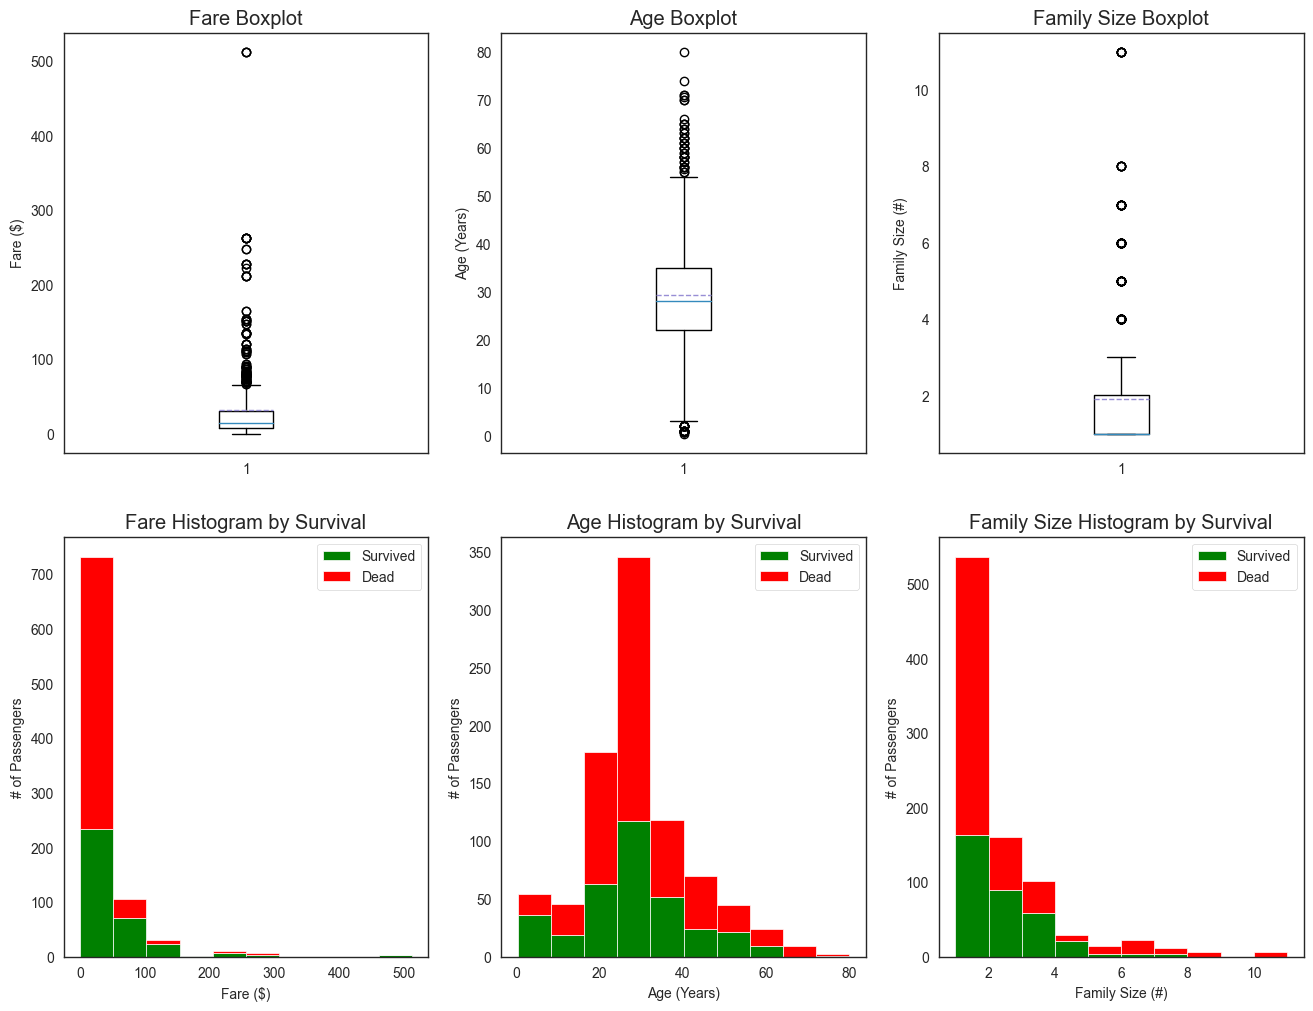

In [9]:
# GRAPHING: plot distributions of quantitative data
plt.figure(figsize=[16, 12])

plt.subplot(231)
plt.boxplot(x=data1['Fare'], showmeans=True, meanline=True)
plt.title('Fare Boxplot')
plt.ylabel('Fare ($)')

plt.subplot(232)
plt.boxplot(data1['Age'], showmeans=True, meanline=True)
plt.title('Age Boxplot')
plt.ylabel('Age (Years)')

plt.subplot(233)
plt.boxplot(data1['FamilySize'], showmeans=True, meanline=True)
plt.title('Family Size Boxplot')
plt.ylabel('Family Size (#)')

plt.subplot(234)
plt.hist(x=[data1[data1['Survived'] == 1]['Fare'], data1[data1['Survived'] == 0]['Fare']], stacked=True,
            color=['g', 'r'], label=['Survived', 'Dead'])
plt.title('Fare Histogram by Survival')
plt.xlabel('Fare ($)')
plt.ylabel('# of Passengers')
plt.legend()

plt.subplot(235)
plt.hist(x=[data1[data1['Survived'] == 1]['Age'], data1[data1['Survived'] == 0]['Age']], stacked=True,
            color=['g', 'r'], label=['Survived', 'Dead'])
plt.title('Age Histogram by Survival')
plt.xlabel('Age (Years)')
plt.ylabel('# of Passengers')
plt.legend()

plt.subplot(236)
plt.hist(x=[data1[data1['Survived'] == 1]['FamilySize'], data1[data1['Survived'] == 0]['FamilySize']], stacked=True,
            color=['g', 'r'], label=['Survived', 'Dead'])
plt.title('Family Size Histogram by Survival')
plt.xlabel('Family Size (#)')
plt.ylabel('# of Passengers')
plt.legend()

<Axes: xlabel='FamilySize', ylabel='Survived'>

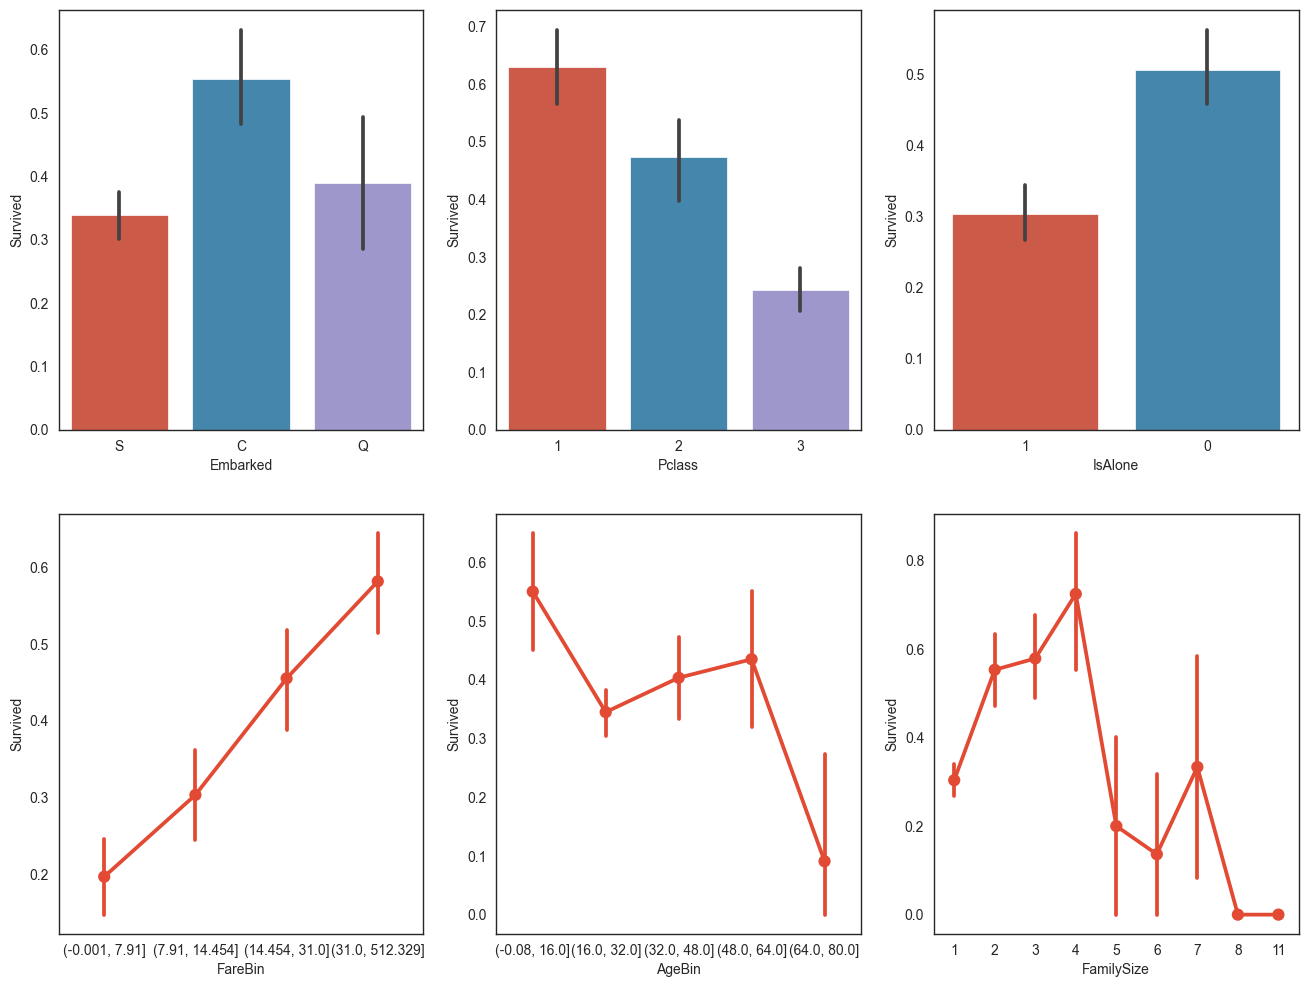

In [10]:
# Graph individual features by survival
fig, saxis = plt.subplots(2, 3, figsize=(16, 12))

sns.barplot(x='Embarked', y='Survived', data=data1, ax=saxis[0, 0])
sns.barplot(x='Pclass', y='Survived', order=[1, 2, 3], data=data1, ax=saxis[0, 1])
sns.barplot(x='IsAlone', y='Survived', order=[1, 0], data=data1, ax=saxis[0, 2])

sns.pointplot(x='FareBin', y='Survived', data=data1, ax=saxis[1, 0])
sns.pointplot(x='AgeBin', y='Survived', data=data1, ax=saxis[1, 1])
sns.pointplot(x='FamilySize', y='Survived', data=data1, ax=saxis[1, 2])

Text(0.5, 1.0, 'Pclass vs Family Size Survival Comparison')

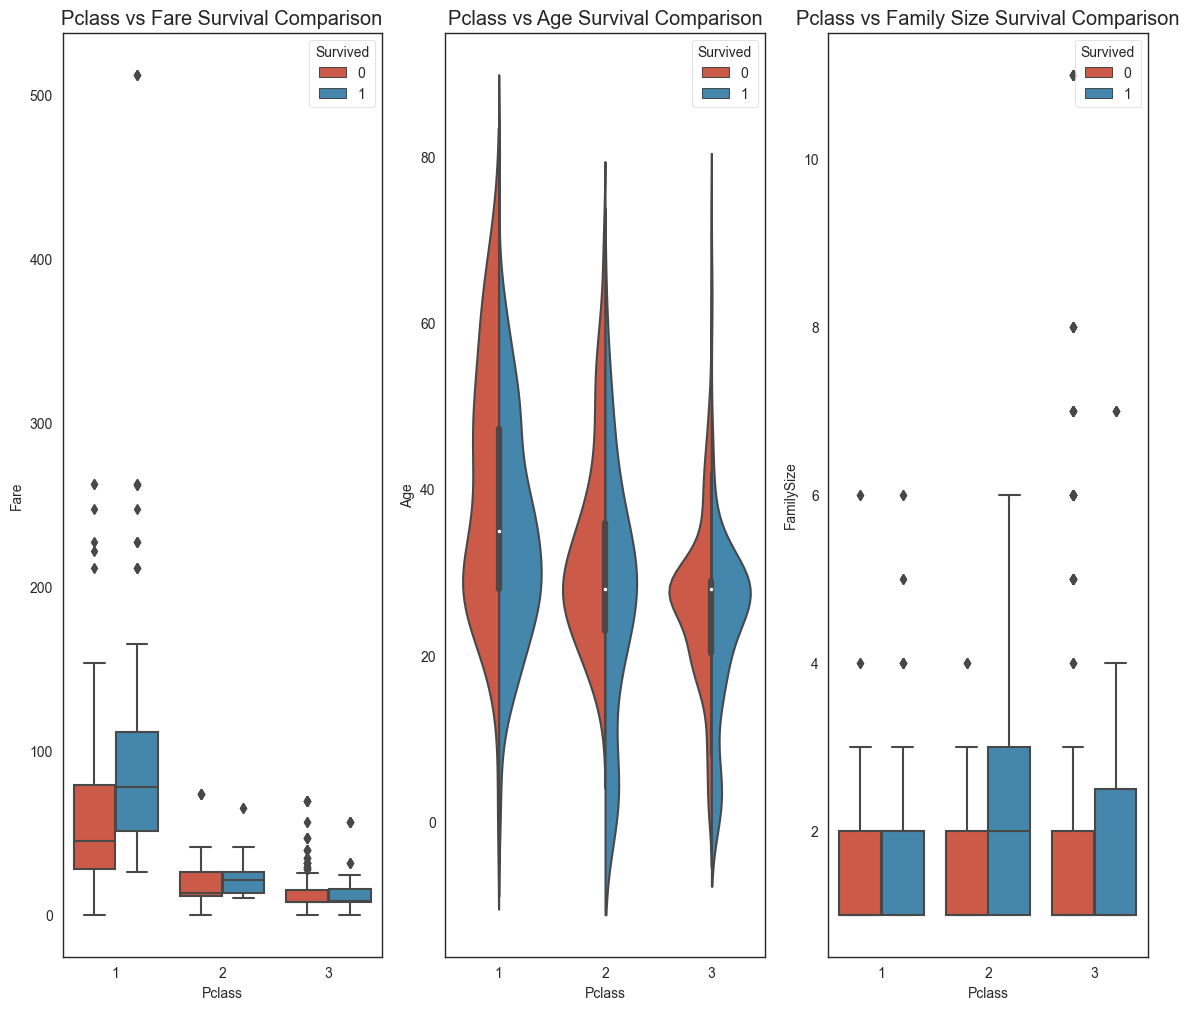

In [11]:
# Graph distribution of qualitative data: Pclass
fig, (axis1, axis2, axis3) = plt.subplots(1, 3, figsize=(14, 12))

sns.boxplot(x='Pclass', y='Fare', hue='Survived', data=data1, ax=axis1)
axis1.set_title('Pclass vs Fare Survival Comparison')

sns.violinplot(x='Pclass', y='Age', hue='Survived', data=data1, split=True, ax=axis2)
axis2.set_title('Pclass vs Age Survival Comparison')

sns.boxplot(x='Pclass', y='FamilySize', hue='Survived', data=data1, ax=axis3)
axis3.set_title('Pclass vs Family Size Survival Comparison')

Text(0.5, 1.0, 'Sex vs IsAlone Survival Comparison')

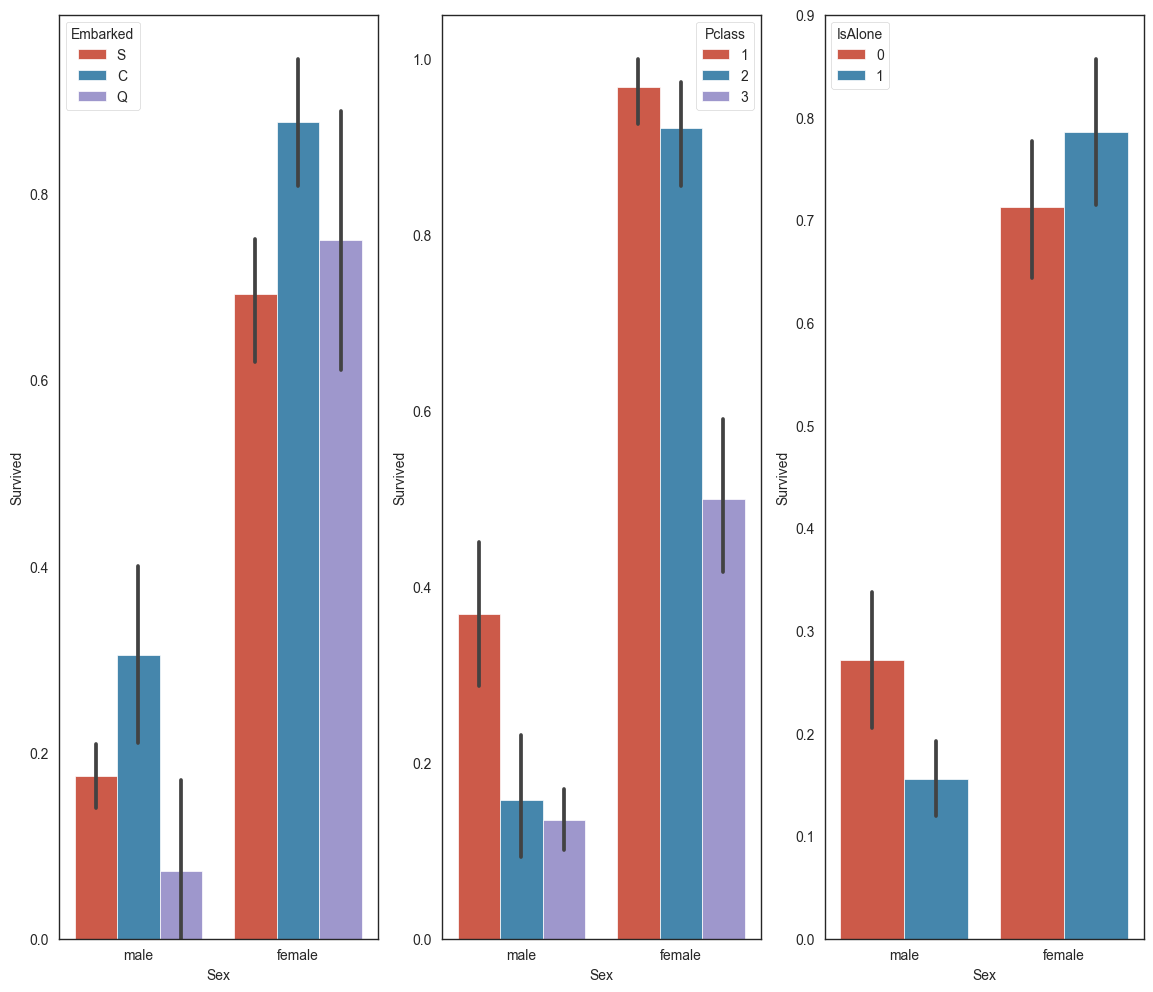

In [12]:
# Graph distribution of quantitive data: Sex
fig, qaxis = plt.subplots(1, 3, figsize=(14, 12))

sns.barplot(x = 'Sex', y = 'Survived', hue = 'Embarked', data=data1, ax = qaxis[0])
axis1.set_title('Sex vs Embarked Survival Comparison')

sns.barplot(x = 'Sex', y = 'Survived', hue = 'Pclass', data=data1, ax  = qaxis[1])
axis1.set_title('Sex vs Pclass Survival Comparison')

sns.barplot(x = 'Sex', y = 'Survived', hue = 'IsAlone', data=data1, ax  = qaxis[2])
axis1.set_title('Sex vs IsAlone Survival Comparison')

<Axes: xlabel='Pclass', ylabel='Survived'>

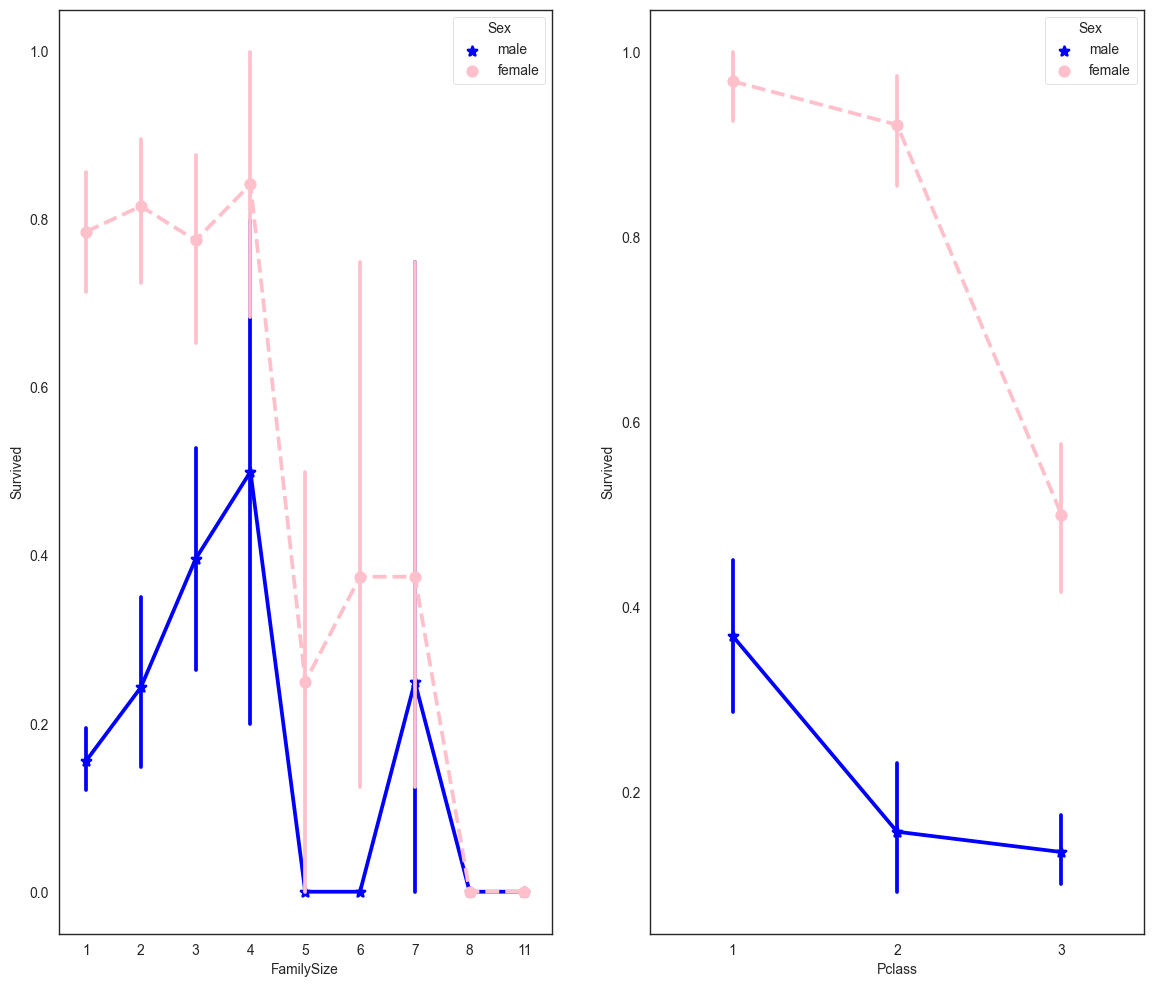

In [13]:
fig, (maxis1, maxis2) = plt.subplots(1, 2, figsize=(14, 12))

# how does family size factor with sex & survival compare
sns.pointplot(x = 'FamilySize', y = 'Survived', hue="Sex", data=data1,
              palette={"male": "blue", "female": "pink"},
              markers=["*", "o"], linestyles=["-", "--"], ax = maxis1)

#how does class factor with sex & survival compare
sns.pointplot(x="Pclass", y="Survived", hue="Sex", data=data1,
              palette={"male": "blue", "female": "pink"},
              markers=["*", "o"], linestyles=["-", "--"], ax = maxis2)

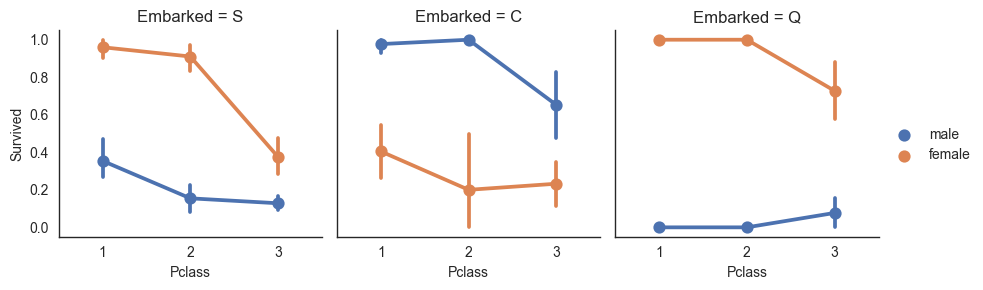

In [14]:
# how does embark port factor with class, sex, and survival compare
e = sns.FacetGrid(data1, col = 'Embarked')
e.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', ci=95.0, palette = 'deep')
e.add_legend()

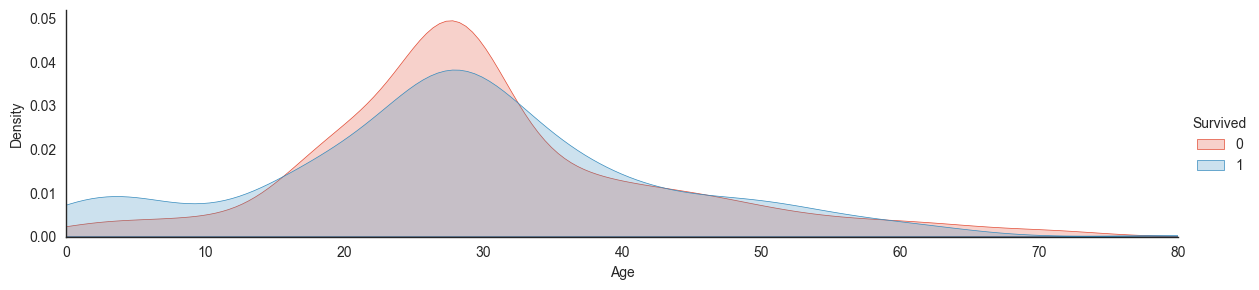

In [15]:
# plot distributions of age of passengers who survived or did not survive
a = sns.FacetGrid(data1, hue = 'Survived', aspect=4)
a.map(sns.kdeplot, 'Age', shade=True)
a.set(xlim=(0, data1['Age'].max()))
a.add_legend()

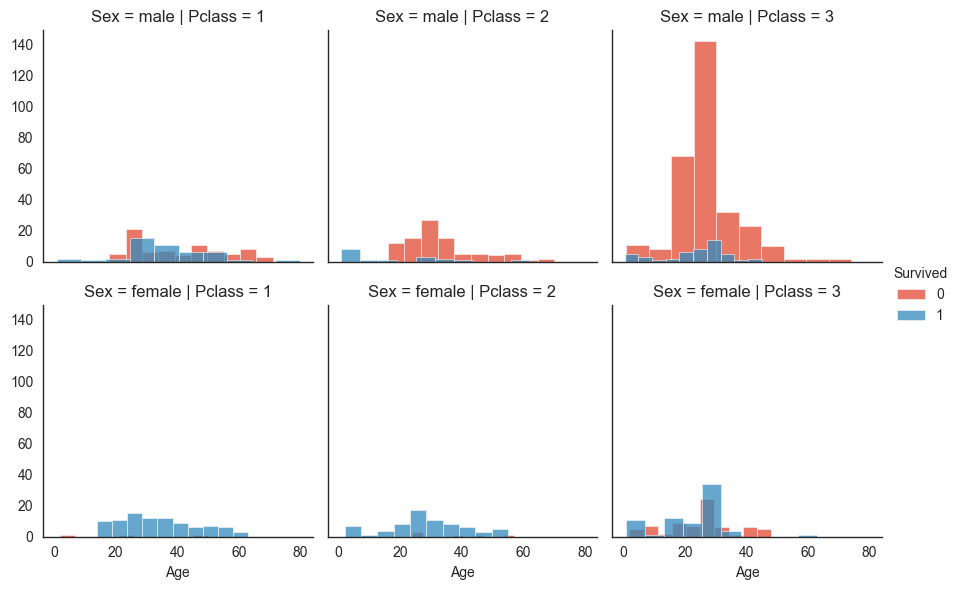

In [16]:
# histogram comparison of Sex, Class, and Age by Survival
h = sns.FacetGrid(data1, row = 'Sex', col = 'Pclass', hue = 'Survived')
h.map(plt.hist, 'Age', alpha = .75)
h.add_legend()

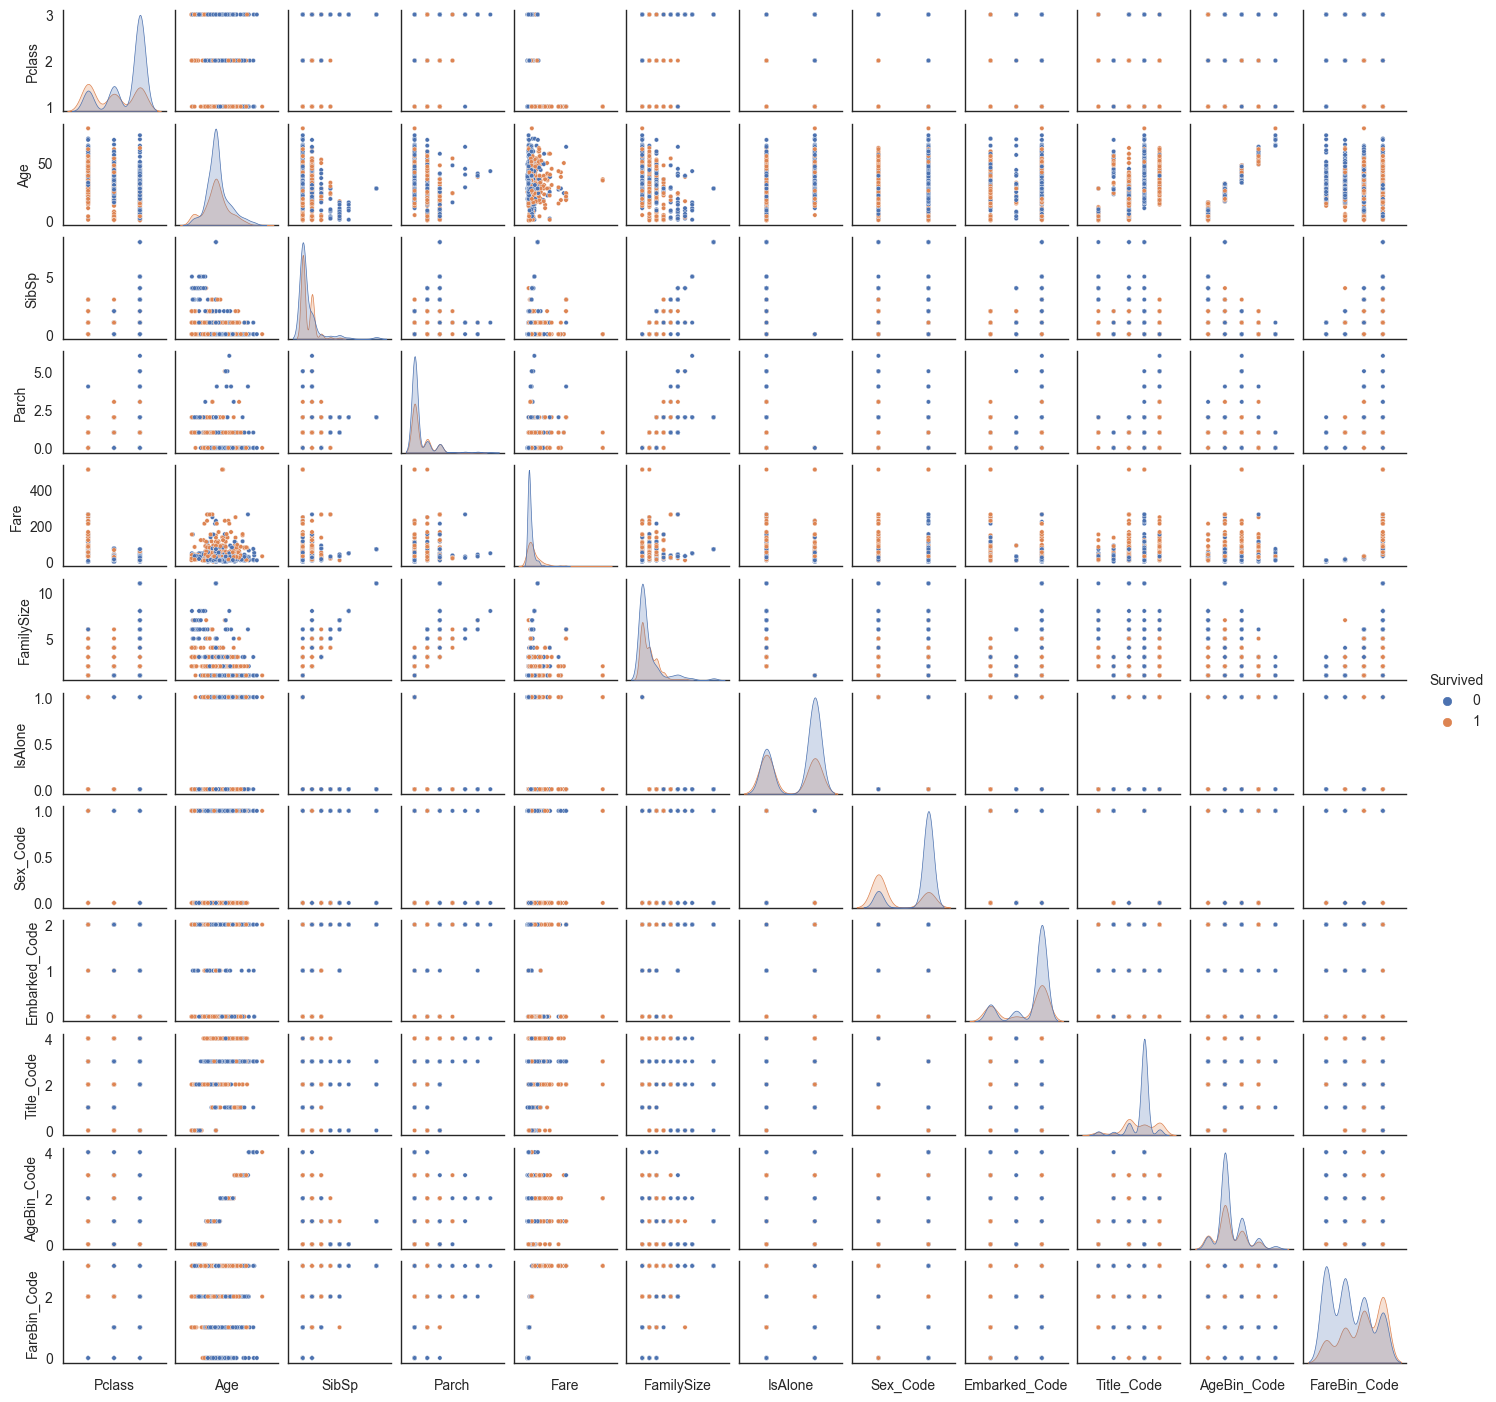

In [17]:
# pair plots of entire dataset
pp = sns.pairplot(data1, hue = 'Survived', palette = 'deep', size=1.2, diag_kind = 'kde', diag_kws=dict(shade=True), plot_kws=dict(s=10))
pp.set(xticklabels=[])

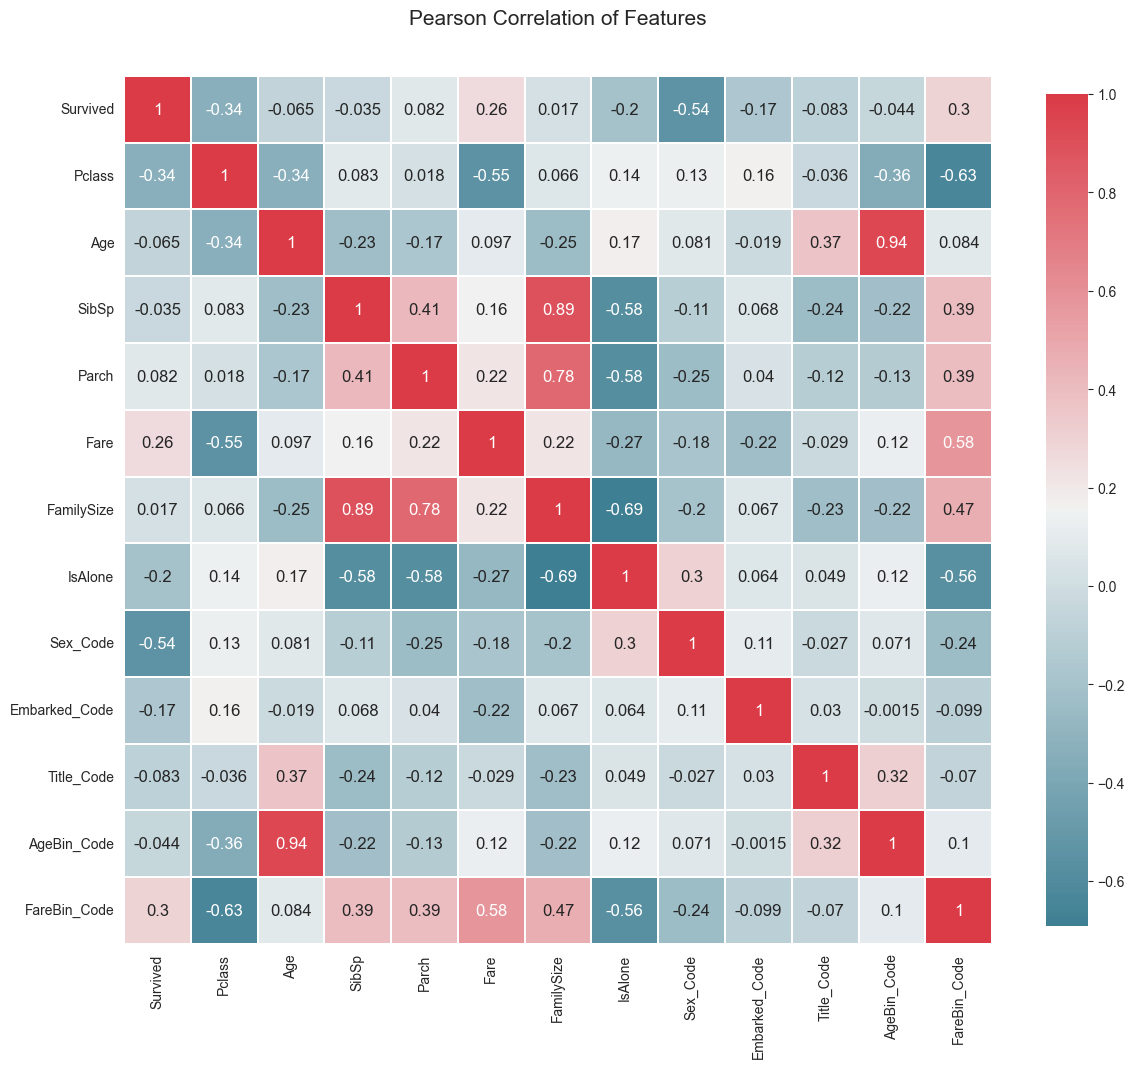

In [18]:
#correlation heatmap of dataset
def correlation_heatmap(df):
    _, ax = plt.subplots(figsize = (14, 12))
    colormap = sns.diverging_palette(220, 10, as_cmap=True)

    _ = sns.heatmap(
        df.corr(),
        cmap=colormap,
        square=True,
        cbar_kws={'shrink': .9},
        ax=ax,
        annot=True,
        linewidths=0.1, vmax=1.0, linecolor='white',
        annot_kws={'fontsize': 12}
    )

    plt.title('Pearson Correlation of Features', y=1.05, size=15)

correlation_heatmap(data1)

In [19]:
# Machine Learning Algorithm (MLA) Selection and Initialization
MLA = [
    # Ensemble Methods
    ensemble.AdaBoostClassifier(),
    ensemble.BaggingClassifier(),
    ensemble.ExtraTreesClassifier(),
    ensemble.GradientBoostingClassifier(),
    ensemble.RandomForestClassifier(),
    
    # Gaussian Processes
    gaussian_process.GaussianProcessClassifier(),

    # GLM
    linear_model.LogisticRegressionCV(),
    linear_model.PassiveAggressiveClassifier(),
    linear_model.RidgeClassifierCV(),
    linear_model.SGDClassifier(),
    linear_model.Perceptron(),

    # Navies Bayes
    naive_bayes.BernoulliNB(),
    naive_bayes.GaussianNB(),

    # Nearest Neighbor
    neighbors.KNeighborsClassifier(),

    # SVM
    svm.SVC(probability=True),
    svm.NuSVC(probability=True),
    svm.LinearSVC(),

    # Trees
    tree.DecisionTreeClassifier(),
    tree.ExtraTreeClassifier(),

    # Discriminant Analysis
    discriminant_analysis.LinearDiscriminantAnalysis(),
    discriminant_analysis.QuadraticDiscriminantAnalysis(),

    # XGBoost
    XGBClassifier()
]

# run model 10x with 60/30 split intentionally leaving out 10%
cv_split = model_selection.ShuffleSplit(n_splits=10, test_size=.3, train_size=.6, random_state=0)

# create table to compare MLA metrics
MLA_columns = ['MLA Name', 'MLA Parameters', 'MLA Train Accuracy Mean', 'MLA Test Accuracy Mean',
                'MLA Test Accuracy 3*STD', 'MLA Time']
MLA_compare = pd.DataFrame(columns=MLA_columns)

# create table to compare MLA predictions
MLA_predict = data1[Target]

# index through MLA and save performance to table
row_index = 0
for alg in MLA:
    # set name and parameters
    MLA_name = alg.__class__.__name__
    MLA_compare.loc[row_index, 'MLA Name'] = MLA_name
    MLA_compare.loc[row_index, 'MLA Parameters'] = str(alg.get_params())

    # score model with cross validation
    cv_results = model_selection.cross_validate(alg, data1[data1_x_bin], data1[Target], cv=cv_split, return_train_score=True)

    MLA_compare.loc[row_index, 'MLA Time'] = cv_results['fit_time'].mean()
    MLA_compare.loc[row_index, 'MLA Train Accuracy Mean'] = cv_results['train_score'].mean()
    MLA_compare.loc[row_index, 'MLA Test Accuracy Mean'] = cv_results['test_score'].mean()

    # if this is a non-bias random sample, then +/-3 standard deviations (std) from the mean, should statistically
    # capture 99.7% of the subsets
    MLA_compare.loc[row_index, 'MLA Test Accuracy 3*STD'] = cv_results['test_score'].std() * 3
    
    # save MLA predictions - see section 6 for usage
    alg.fit(data1[data1_x_bin], data1[Target])
    MLA_predict[MLA_name] = alg.predict(data1[data1_x_bin])

    row_index += 1

# print and sort table
MLA_compare.sort_values(by=['MLA Test Accuracy Mean'], ascending=False, inplace=True)
MLA_compare

,MLA Name,MLA Parameters,MLA Train Accuracy Mean,MLA Test Accuracy Mean,MLA Test Accuracy 3*STD,MLA Time
4,RandomForestClassifier,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",0.895131,0.83097,0.068284,0.358
14,SVC,"{'C': 1.0, 'break_ties': False, 'cache_size': ...",0.835206,0.827612,0.040916,0.068193
21,XGBClassifier,"{'objective': 'binary:logistic', 'use_label_en...",0.890449,0.826493,0.06177,0.082702
15,NuSVC,"{'break_ties': False, 'cache_size': 200, 'clas...",0.834082,0.826119,0.045663,0.075399
2,ExtraTreesClassifier,"{'bootstrap': False, 'ccp_alpha': 0.0, 'class_...",0.895131,0.825,0.061608,0.242692
3,GradientBoostingClassifier,"{'ccp_alpha': 0.0, 'criterion': 'friedman_mse'...",0.866667,0.822761,0.049873,0.163001
17,DecisionTreeClassifier,"{'ccp_alpha': 0.0, 'class_weight': None, 'crit...",0.895131,0.821642,0.04976,0.004598
1,BaggingClassifier,"{'base_estimator': 'deprecated', 'bootstrap': ...",0.890637,0.820149,0.043585,0.050598
18,ExtraTreeClassifier,"{'ccp_alpha': 0.0, 'class_weight': None, 'crit...",0.895131,0.817164,0.061312,0.006101
0,AdaBoostClassifier,"{'algorithm': 'SAMME.R', 'base_estimator': 'de...",0.820412,0.81194,0.049861,0.1797


Text(0, 0.5, 'Algorithm')

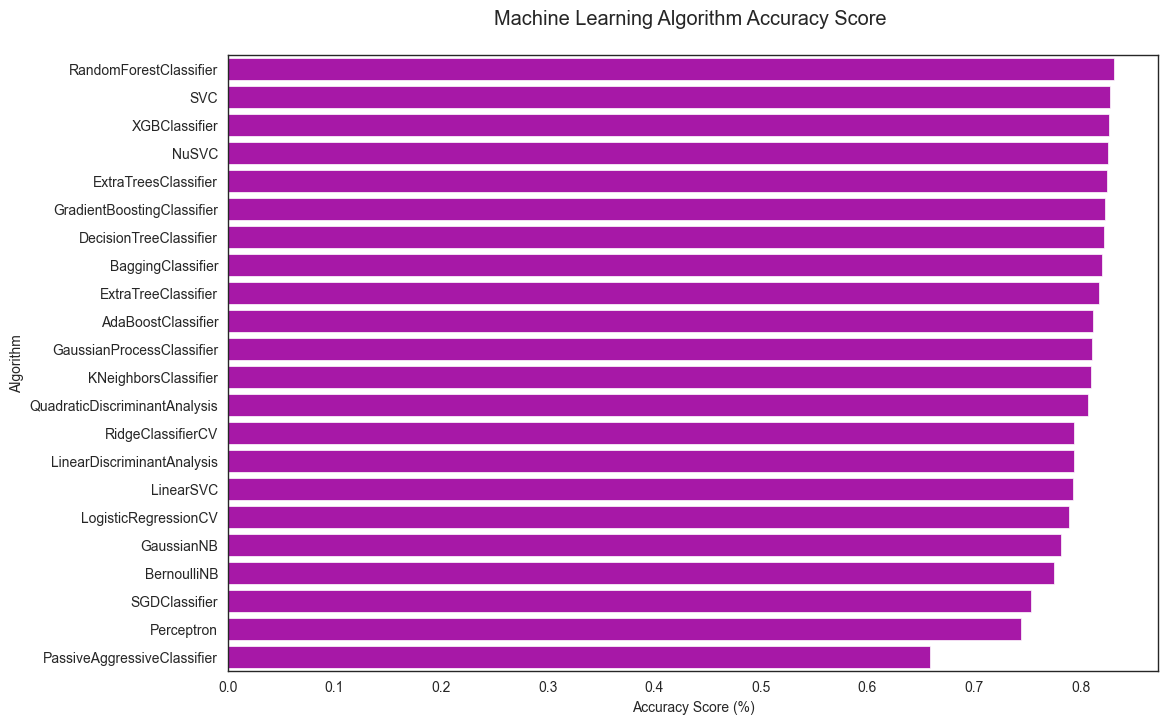

In [20]:
# graph barplot comparing MLA test accuracy results
sns.barplot(x='MLA Test Accuracy Mean', y='MLA Name', data=MLA_compare, color='m')

# prettify using pyplot
plt.title('Machine Learning Algorithm Accuracy Score \n')
plt.xlabel('Accuracy Score (%)')
plt.ylabel('Algorithm')

In [21]:
for index, row in data1.iterrows():
    # Random float x, 0.0 <= x < 1.0
    if random.random() > .5:         
        data1._set_value(index, 'Random_Predict', 1)
    else: 
        data1._set_value(index, 'Random_Predict', 0)

data1['Random_Score'] = 0
data1.loc[(data1['Survived'] == data1['Random_Predict']), 'Random_Score'] = 1
print('Coin Flip Model Accuracy: {:.2f}%'.format(data1['Random_Score'].mean() * 100))

print('Coin Flip Model Accuracy w/SciKit: {:.2f}%'.format(metrics.accuracy_score(data1['Survived'], data1['Random_Predict']) * 100))

Coin Flip Model Accuracy: 49.05%
Coin Flip Model Accuracy w/SciKit: 49.05%


In [22]:
pivot_female = data1[data1.Sex=='female'].groupby(['Sex','Pclass', 'Embarked','FareBin'])['Survived'].mean()
print("Survival Decision Tree w/Female Node: \n", pivot_female)

pivot_male = data1[data1.Sex=='male'].groupby(['Sex','Title'])['Survived'].mean()
print("Survival Decision Tree w/Male Node: \n", pivot_male)

Survival Decision Tree w/Female Node: 
 Sex     Pclass  Embarked  FareBin        
female  1       C         (-0.001, 7.91]          NaN
                          (7.91, 14.454]          NaN
                          (14.454, 31.0]     0.666667
                          (31.0, 512.329]    1.000000
                Q         (-0.001, 7.91]          NaN
                          (7.91, 14.454]          NaN
                          (14.454, 31.0]          NaN
                          (31.0, 512.329]    1.000000
                S         (-0.001, 7.91]          NaN
                          (7.91, 14.454]          NaN
                          (14.454, 31.0]     1.000000
                          (31.0, 512.329]    0.955556
        2       C         (-0.001, 7.91]          NaN
                          (7.91, 14.454]     1.000000
                          (14.454, 31.0]     1.000000
                          (31.0, 512.329]    1.000000
                Q         (-0.001, 7.91]          NaN


In [23]:
def mytree(df):

    # initialize table to store predictions
    Model = pd.DataFrame(data={'Predict': []})
    male_title = ['Master']

    for index, row in df.iterrows():

        # Question 1: Were you on the Titanic; majority died
        Model.loc[index, 'Predict'] = 0

        # Quetions 2: Are you female; majority survived
        if (df.loc[index, 'Sex'] == 'female'):
            Model.loc[index, 'Predict'] = 1

        #Question 3A Female - Class and Question 4 Embarked gain minimum information

        #Question 5B Female - FareBin; set anything less than .5 in female node decision tree back to 0       
        if ((df.loc[index, 'Sex'] == 'female') & 
            (df.loc[index, 'Pclass'] == 3) & 
            (df.loc[index, 'Embarked'] == 'S')  &
            (df.loc[index, 'Fare'] > 8)

           ):
                  Model.loc[index, 'Predict'] = 0

        #Question 3B Male: Title; set anything greater than .5 to 1 for majority survived
        if ((df.loc[index, 'Sex'] == 'male') &
            (df.loc[index, 'Title'] in male_title)
            ):
            Model.loc[index, 'Predict'] = 1
    return Model

# model data
Tree_Predict = mytree(data1)
print('Decision Tree Model Accuracy/Precision Score: {:.2f}%\n'.format(metrics.accuracy_score(data1['Survived'], Tree_Predict) * 100))

print(metrics.classification_report(data1['Survived'], Tree_Predict))

Decision Tree Model Accuracy/Precision Score: 82.04%

              precision    recall  f1-score   support

           0       0.82      0.91      0.86       549
           1       0.82      0.68      0.75       342

    accuracy                           0.82       891
   macro avg       0.82      0.79      0.80       891
weighted avg       0.82      0.82      0.82       891



Confusion Matrix, Without Normalization
[[497  52]
 [108 234]]
Normalized Confusion Matrix
[[0.91 0.09]
 [0.32 0.68]]


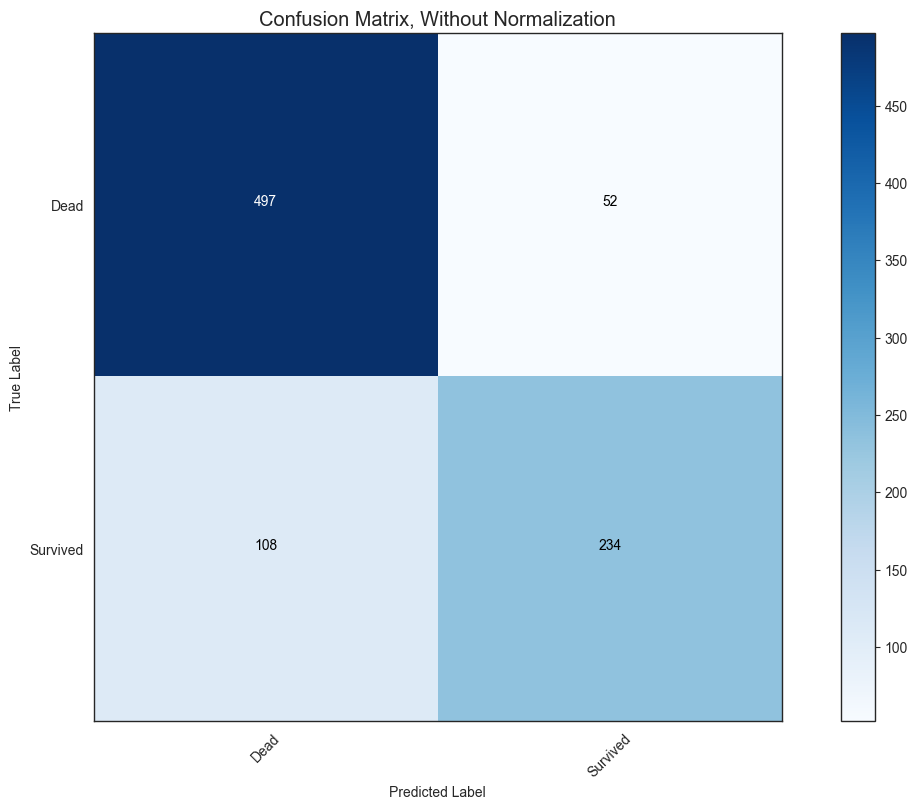

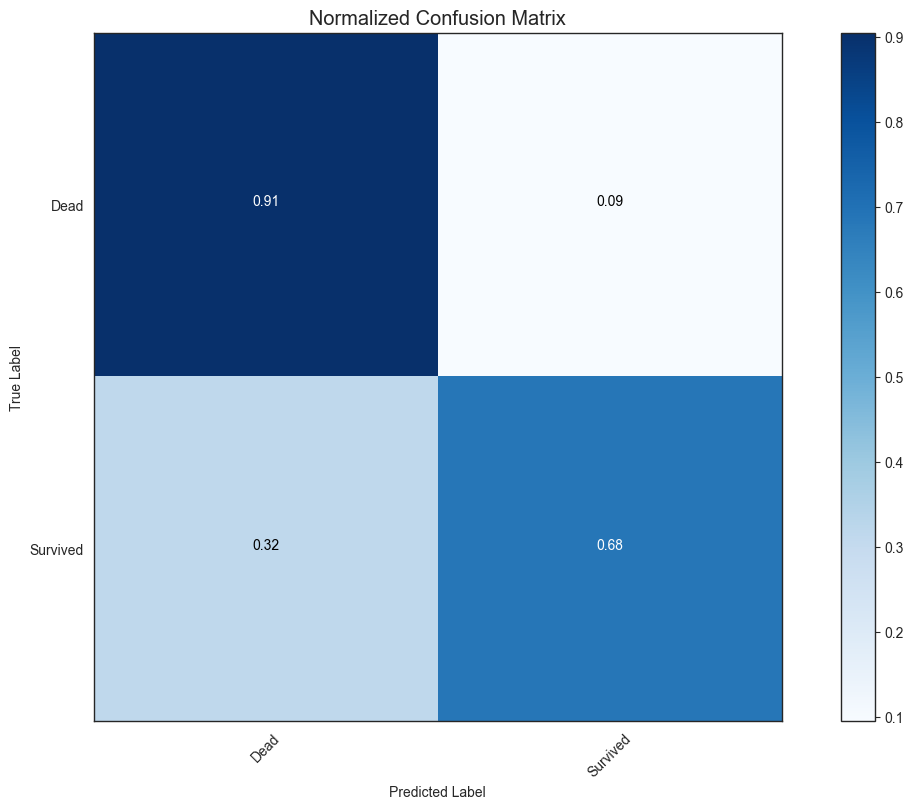

In [24]:
# Plot Accuracy Summary
import itertools
def plot_confusion_martix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print('Normalized Confusion Matrix')
    else:
        print('Confusion Matrix, Without Normalization')
    
    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')
    
    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

# Compute confusion matrix
cnf_matrix = metrics.confusion_matrix(data1['Survived'], Tree_Predict)
np.set_printoptions(precision=2)

class_names = ['Dead', 'Survived']

# Plot non-normalized confusion matrix
class_names = ['Dead', 'Survived']
plt.figure()
plot_confusion_martix(cnf_matrix, classes=class_names, title='Confusion Matrix, Without Normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_martix(cnf_matrix, classes=class_names, normalize=True, title='Normalized Confusion Matrix')



In [25]:
# base model
dtree = tree.DecisionTreeClassifier(random_state=0)
base_results = model_selection.cross_validate(dtree, data1[data1_x_bin], data1[Target], cv=cv_split, return_train_score=True)
dtree.fit(data1[data1_x_bin], data1[Target])

print('BEFORE DT Parameters: ', dtree.get_params())
print("BEFORE DT Training w/bin score mean: {:.2f}".format(base_results['train_score'].mean() * 100))
print("BEFORE DT Test w/bin score mean: {:.2f}".format(base_results['test_score'].mean() * 100))
print("BEFORE DT Test w/bin score 3*std: +/- {:.2f}".format(base_results['test_score'].std() * 100 * 3))
print('-' * 10)

# tune hyperparameters
param_grid = {'criterion': ['gini', 'entropy'],
              'max_depth': [2, 4, 6, 8, 10, None],
              'random_state': [0]
             }

tune_model = model_selection.GridSearchCV(tree.DecisionTreeClassifier(), param_grid=param_grid, scoring='roc_auc', cv=cv_split, return_train_score=True)
tune_model.fit(data1[data1_x_bin], data1[Target])

print('AFTER DT Parameters: ', tune_model.best_params_)
print("AFTER DT Training w/bin score mean: {:.2f}".format(tune_model.cv_results_['mean_train_score'][tune_model.best_index_] * 100))

print("AFTER DT Test w/bin score mean: {:.2f}".format(tune_model.cv_results_['mean_test_score'][tune_model.best_index_] * 100))
print("AFTER DT Test w/bin score 3*std: +/- {:.2f}".format(tune_model.cv_results_['std_test_score'][tune_model.best_index_] * 100 * 3))
print('-' * 10)

BEFORE DT Parameters:  {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 0, 'splitter': 'best'}
BEFORE DT Training w/bin score mean: 89.51
BEFORE DT Test w/bin score mean: 82.09
BEFORE DT Test w/bin score 3*std: +/- 5.57
----------
AFTER DT Parameters:  {'criterion': 'gini', 'max_depth': 4, 'random_state': 0}
AFTER DT Training w/bin score mean: 89.35
AFTER DT Test w/bin score mean: 87.40
AFTER DT Test w/bin score 3*std: +/- 5.00
----------


In [26]:
#base model
print('BEFORE DT RFE Training Shape Old: ', data1[data1_x_bin].shape) 
print('BEFORE DT RFE Training Columns Old: ', data1[data1_x_bin].columns.values)

print("BEFORE DT RFE Training w/bin score mean: {:.2f}". format(base_results['train_score'].mean()*100)) 
print("BEFORE DT RFE Test w/bin score mean: {:.2f}". format(base_results['test_score'].mean()*100))
print("BEFORE DT RFE Test w/bin score 3*std: +/- {:.2f}". format(base_results['test_score'].std()*100*3))
print('-'*10)

#feature selection
dtree_rfe = feature_selection.RFECV(dtree, step = 1, scoring = 'accuracy', cv = cv_split)
dtree_rfe.fit(data1[data1_x_bin], data1[Target])

#transform x&y to reduced features and fit new model
X_rfe = data1[data1_x_bin].columns.values[dtree_rfe.get_support()]
rfe_results = model_selection.cross_validate(dtree, data1[X_rfe], data1[Target], cv = cv_split, return_train_score=True)

print('AFTER DT RFE Training Shape New: ', data1[X_rfe].shape) 
print('AFTER DT RFE Training Columns New: ', X_rfe)

print("AFTER DT RFE Training w/bin score mean: {:.2f}". format(rfe_results['train_score'].mean()*100)) 
print("AFTER DT RFE Test w/bin score mean: {:.2f}". format(rfe_results['test_score'].mean()*100))
print("AFTER DT RFE Test w/bin score 3*std: +/- {:.2f}". format(rfe_results['test_score'].std()*100*3))
print('-'*10)

# tune rfe model
rfe_tune_model = model_selection.GridSearchCV(tree.DecisionTreeClassifier(), param_grid=param_grid, scoring = 'roc_auc', cv = cv_split, return_train_score=True)
rfe_tune_model.fit(data1[X_rfe], data1[Target])

print('AFTER DT RFE Tuned Parameters: ', rfe_tune_model.best_params_)
print("AFTER DT RFE Tuned Training w/bin score mean: {:.2f}". format(rfe_tune_model.cv_results_['mean_train_score'][tune_model.best_index_]*100))
print("AFTER DT RFE Tuned Test w/bin score mean: {:.2f}". format(rfe_tune_model.cv_results_['mean_test_score'][tune_model.best_index_]*100))
print("AFTER DT RFE Tuned Test w/bin score 3*std: +/- {:.2f}". format(rfe_tune_model.cv_results_['std_test_score'][tune_model.best_index_]*100*3))
print('-'*10)

BEFORE DT RFE Training Shape Old:  (891, 7)
BEFORE DT RFE Training Columns Old:  ['Sex_Code' 'Pclass' 'Embarked_Code' 'Title_Code' 'FamilySize'
 'AgeBin_Code' 'FareBin_Code']
BEFORE DT RFE Training w/bin score mean: 89.51
BEFORE DT RFE Test w/bin score mean: 82.09
BEFORE DT RFE Test w/bin score 3*std: +/- 5.57
----------
AFTER DT RFE Training Shape New:  (891, 6)
AFTER DT RFE Training Columns New:  ['Sex_Code' 'Pclass' 'Title_Code' 'FamilySize' 'AgeBin_Code'
 'FareBin_Code']
AFTER DT RFE Training w/bin score mean: 88.16
AFTER DT RFE Test w/bin score mean: 83.06
AFTER DT RFE Test w/bin score 3*std: +/- 6.22
----------
AFTER DT RFE Tuned Parameters:  {'criterion': 'gini', 'max_depth': 4, 'random_state': 0}
AFTER DT RFE Tuned Training w/bin score mean: 89.39
AFTER DT RFE Tuned Test w/bin score mean: 87.34
AFTER DT RFE Tuned Test w/bin score 3*std: +/- 6.21
----------


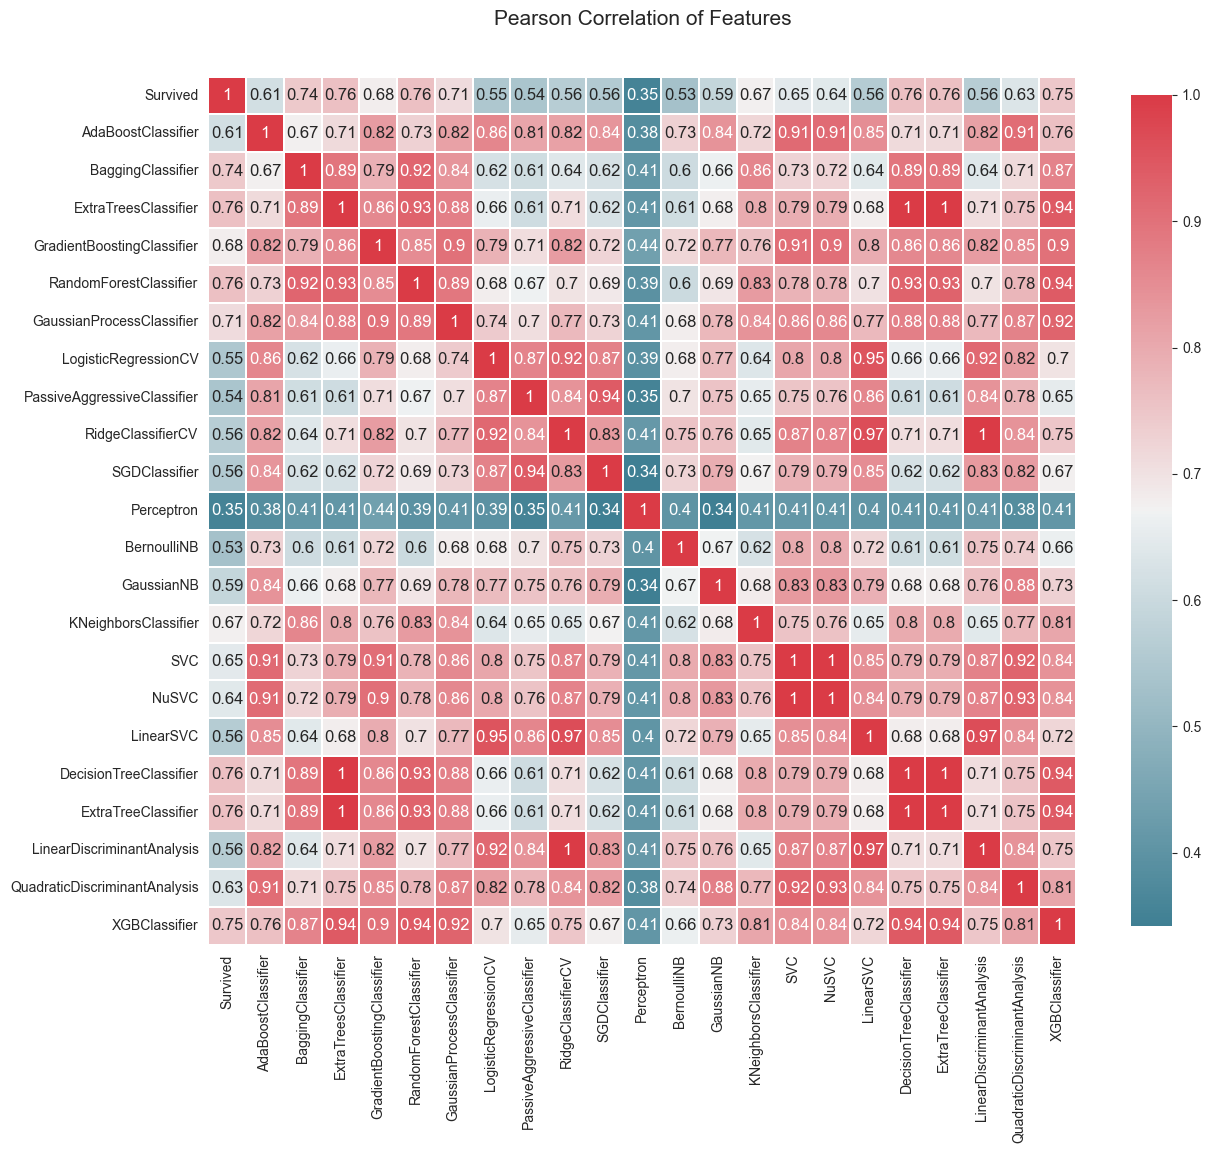

In [28]:
correlation_heatmap(MLA_predict)

In [29]:
#removed models w/o attribute 'predict_proba' required for vote classifier and models with a 1.0 correlation to another model
vote_est = [
    ('ada', ensemble.AdaBoostClassifier()),
    ('bc', ensemble.BaggingClassifier()),
    ('etc',ensemble.ExtraTreesClassifier()),
    ('gbc', ensemble.GradientBoostingClassifier()),
    ('rfc', ensemble.RandomForestClassifier()),
    ('gpc', gaussian_process.GaussianProcessClassifier()),
    ('lr', linear_model.LogisticRegressionCV()),
    ('bnb', naive_bayes.BernoulliNB()),
    ('gnb', naive_bayes.GaussianNB()),
    ('knn', neighbors.KNeighborsClassifier()),
    ('svc', svm.SVC(probability=True)),
    ('xgb', XGBClassifier())
]

#Hard Vote or majority rules
vote_hard = ensemble.VotingClassifier(estimators = vote_est , voting = 'hard')
vote_hard_cv = model_selection.cross_validate(vote_hard, data1[data1_x_bin], data1[Target], cv  = cv_split, return_train_score=True)
vote_hard.fit(data1[data1_x_bin], data1[Target])

print("Hard Voting Training w/bin score mean: {:.2f}". format(vote_hard_cv['train_score'].mean()*100)) 
print("Hard Voting Test w/bin score mean: {:.2f}". format(vote_hard_cv['test_score'].mean()*100))
print("Hard Voting Test w/bin score 3*std: +/- {:.2f}". format(vote_hard_cv['test_score'].std()*100*3))
print('-'*10)

#Soft Vote or weighted probabilities
vote_soft = ensemble.VotingClassifier(estimators = vote_est , voting = 'soft')
vote_soft_cv = model_selection.cross_validate(vote_soft, data1[data1_x_bin], data1[Target], cv  = cv_split, return_train_score=True)
vote_soft.fit(data1[data1_x_bin], data1[Target])

print("Soft Voting Training w/bin score mean: {:.2f}". format(vote_soft_cv['train_score'].mean()*100)) 
print("Soft Voting Test w/bin score mean: {:.2f}". format(vote_soft_cv['test_score'].mean()*100))
print("Soft Voting Test w/bin score 3*std: +/- {:.2f}". format(vote_soft_cv['test_score'].std()*100*3))
print('-'*10)

Hard Voting Training w/bin score mean: 87.27
Hard Voting Test w/bin score mean: 82.09
Hard Voting Test w/bin score 3*std: +/- 4.39
----------
Soft Voting Training w/bin score mean: 87.75
Soft Voting Test w/bin score mean: 82.57
Soft Voting Test w/bin score 3*std: +/- 5.51
----------


In [34]:
#prepare data for modeling
print(data_val.info())
print("-"*10)

data_val['Survived'] = mytree(data_val).astype(int)

data_val['Survived'] = vote_hard.predict(data_val[data1_x_bin])

submit = data_val[['PassengerId','Survived']]
print('Validation Data Distribution: \n', data_val['Survived'].value_counts(normalize = True))
submit.sample(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   PassengerId    418 non-null    int64   
 1   Pclass         418 non-null    int64   
 2   Name           418 non-null    object  
 3   Sex            418 non-null    object  
 4   Age            418 non-null    float64 
 5   SibSp          418 non-null    int64   
 6   Parch          418 non-null    int64   
 7   Ticket         418 non-null    object  
 8   Fare           418 non-null    float64 
 9   Cabin          91 non-null     object  
 10  Embarked       418 non-null    object  
 11  FamilySize     418 non-null    int64   
 12  IsAlone        418 non-null    int64   
 13  Title          418 non-null    object  
 14  FareBin        418 non-null    category
 15  AgeBin         418 non-null    category
 16  Sex_Code       418 non-null    int32   
 17  Embarked_Code  418 non-null    int3

,PassengerId,Survived
368,1260,1
218,1110,1
336,1228,0
49,941,1
412,1304,1
30,922,0
367,1259,1
403,1295,0
163,1055,0
46,938,1
